# The London Tube as a Graph

Representing a rail network as a graph is nothing new, its the most obvious way to do it. Nodes are the stations and edges are the lines between them. But what happens when you apply algorithms like PageSort to the graph? Will it be able to pick out the stations a human would intuitively pick out as important? Lets find out

Imports first, I'll use NetworkX as the graph library. It seems to be the easiest and most full featured library around.

In [1]:
%matplotlib inline 

import colorsys 
import numpy as np 
import pandas as pd 
import networkx as nx 
import matplotlib.pyplot as plt 
from collections import Counter 
from bokeh.plotting import figure, show 
from bokeh.resources import CDN 
from bokeh.io import output_notebook 
output_notebook( resources=CDN ) 

pd.set_option('max_colwidth', 200) 

Loading BokehJS ...

In [38]:
# https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/London_Underground_with_Greater_London_map.svg/900px-London_Underground_with_Greater_London_map.svg.png 

tubemap = Image("https://en.wikipedia.org/wiki/File:London_Underground_with_Greater_London_map.svg") 

tubemap.show()

NameError: name 'Image' is not defined

In [17]:
tabs = pd.read_html("https://en.wikipedia.org/wiki/London_Underground_infrastructure", flavor = 'bs4', match='Bakerloo line') 

len(tabs) 

1

In [18]:
df = tabs[0][:11] # Selecting only the needed table, which in this case is the first 10 rows of the first table. 

new_df = pd.DataFrame() # Creating a new dataframe to make changes to the column names in the current dataframe. 

new_df['name'] = df['Name'].str.replace(' line', '', regex=True) 
new_df['name'] = new_df['name'].str.replace('+', '', regex=True) 
new_df['colour_on_map'] = df['Mapcolour[54]'] 
new_df['first_operated'] = df['Firstoperated'].str.replace('†', '', regex=True) 
new_df['first_operated'] = new_df['first_operated'].str.replace('~', '', regex=True) 
new_df['type'] = df['Type♯'].str.replace('DT', 'Deep Tube', regex=True) 
new_df['type'] = new_df['type'].str.replace('SS', 'Sub-surface', regex=True) 
new_df['length_in_miles'] = [float(i[:4]) for i in df['Length(miles)']] 
new_df['num_of_stations'] = df['No.Sta'].astype('int') 

new_df.index = new_df.index + 1 

new_df.to_csv('../Data/TfL-Station-Data-detailed/Transformed/Wiki/Lines.csv', index=True) 

new_df.head(3) 

name colour_on_map first_operated         type  length_in_miles  \
1  Bakerloo   Light Brown           1906    Deep Tube             14.5   
2   Central           Red           1900    Deep Tube             46.0   
3    Circle        Yellow           1884  Sub-surface             17.0   

   num_of_stations  
1               25  
2               49  
3               36

### Loading in other dataframes 

In [94]:
lines = pd.read_csv('../Data/TfL-Station-Data-detailed/Transformed/Wiki/Lines.csv', index_col=0) 
stations = pd.read_csv('../Data/TfL-Station-Data-detailed/Transformed/Stations_Coodinates.csv', index_col=0) 
connections = pd.read_csv('../Data/TfL-Station-Data-detailed/Transformed/LU_Loading_Data.csv') 

In [95]:
stations.head(3) 

unique_id          name  latitude  longitude  total_lines fare_zones
id                                                                        
1   940GZZLUACT    Acton Town   51.5028    -0.2801            2          3
2   940GZZLUALD       Aldgate   51.5143    -0.0755            2          1
3   940GZZLUADE  Aldgate East   51.5154    -0.0726            2          1

In [96]:
connections = connections.drop(['line_direction', 'platform_direction'], axis=1) 
connections.head(3) 

from_naptan    to_naptan         from_station     to_station      line  \
0  940GZZLUHAW  940GZZLUKEN  Harrow & Wealdstone         Kenton  Bakerloo   
1  940GZZLUKEN  940GZZLUSKT               Kenton   South Kenton  Bakerloo   
2  940GZZLUSKT  940GZZLUNWY         South Kenton  North Wembley  Bakerloo   

  direction  
0   Inbound  
1   Inbound  
2   Inbound

We can create a native graph super easily from this.

## A simplified graph

In [97]:
def pseudocolor(val):
    h = (1.0 - val) * 120 / 360
    r, g, b = colorsys.hsv_to_rgb(h, 1., 1.)
    return r * 255, g * 255, b * 255 

In [98]:
graph = nx.Graph() 
# graph.add_nodes_from(stations['name']) 
graph.add_edges_from(list(zip(connections['from_station'], connections['to_station'])), line = connections['line']) 

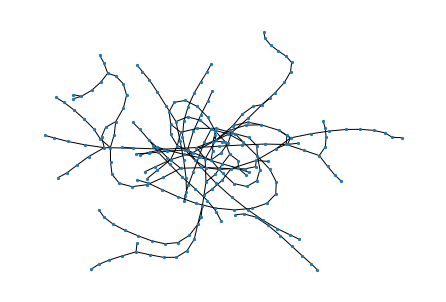

In [26]:
nx.draw(graph, node_size=5) 

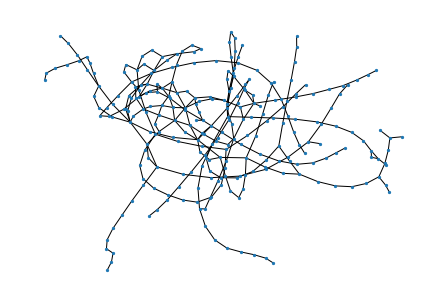

In [68]:
nx.draw(graph, node_size=5) 

Already we can do some kind of interesting stuff, like get a reasonable path between Oxford Circus and Canary Wharf

In [99]:
nx.shortest_path(graph, 'Oxford Circus', 'Canary Wharf') 

['Oxford Circus',
 'Green Park',
 'Westminster',
 'Waterloo',
 'Southwark',
 'London Bridge',
 'Bermondsey',
 'Canada Water',
 'Canary Wharf']

And run PageRank on the network!

In [100]:
pagerank = nx.pagerank_numpy(graph)
pagerank = pd.DataFrame(pagerank.items(), columns=['name', 'pagerank'])
stations = pd.merge(stations, pagerank, on='name') 

C:\Users\Hakim Balogun\AppData\Local\Temp\ipykernel_5976\3355103146.py:1: DeprecationWarning: networkx.pagerank_numpy is deprecated and will be removed in NetworkX 3.0, use networkx.pagerank instead.
  pagerank = nx.pagerank_numpy(graph)
c:\Users\Hakim Balogun\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\algorithms\link_analysis\pagerank_alg.py:354: FutureWarning: google_matrix will return an np.ndarray instead of a np.matrix in
NetworkX version 3.0.
  M = google_matrix(


In [101]:
stations.sort_values('pagerank', ascending=False).head(10) 

unique_id                name  latitude  longitude  total_lines  \
227       HUBWAT            Waterloo   51.5036    -0.1143            4   
9    940GZZLUBST        Baker Street   51.5226    -0.1571            5   
214  940GZZLUTNG       Turnham Green   51.4951    -0.2547            2   
60   940GZZLUECT        Earl's Court   51.4920    -0.1973            2   
230  940GZZLUWYP        Wembley Park   51.5635    -0.2795            2   
199  940GZZLUSKW           Stockwell   51.4723    -0.1230            2   
159  940GZZLUOXC       Oxford Circus   51.5150    -0.1415            3   
86   940GZZLUGPK          Green Park   51.5067    -0.1428            3   
102  940GZZLUHBN             Holborn   51.5174    -0.1200            2   
38        HUBCFO  Chalfont & Latimer   51.6679    -0.5610            1   

    fare_zones  pagerank  
227          1  0.007748  
9            1  0.007738  
214        2|3  0.007454  
60         1|2  0.007004  
230          4  0.006757  
199          2  0.006697  
159          1  0.006594  
86           1  0.006591  
102          1  0.006585  
38           8  0.006502

Those results look incredibly good considering how little work we've put in! With the exception of Turnham Green, this seems like a very reasonable list of the most important tube stations in London. And this is all without taking into account the Overground network, or looking at any traffic stats!

NetworkX also implements the [HITS algorithm](https://en.wikipedia.org/wiki/HITS_algorithm). It was originally designed to differenciate between web pages which acted as hubs of information and those which acted as authoritive sourves of information. It does this by looking at incoming and outgoing edges from each node. In an undirected graph (like we're using), incoming  and outgoing edges are the same, but the results I found when I applied it to the Tube graph were quite interesting!

In [102]:
hits = nx.hits(graph, max_iter=1000)[0]
hits = pd.DataFrame(hits.items(), columns=['name', 'hits']) 
stations = pd.merge(stations, hits, on='name') 

c:\Users\Hakim Balogun\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


In [103]:
stations.sort_values('hits', ascending=False).head(10) 

unique_id                  name  latitude  longitude  total_lines  \
227       HUBWAT              Waterloo   51.5036    -0.1143            4   
86   940GZZLUGPK            Green Park   51.5067    -0.1428            3   
159  940GZZLUOXC         Oxford Circus   51.5150    -0.1415            3   
239       HUBWSM           Westminster   51.5010    -0.1254            3   
22        HUBBDS           Bond Street   51.5142    -0.1494            2   
69   940GZZLUEMB            Embankment   51.5074    -0.1223            4   
11        HUBBAN                  Bank   51.5133    -0.0886            4   
9    940GZZLUBST          Baker Street   51.5226    -0.1571            5   
209       HUBTCR  Tottenham Court Road   51.5165    -0.1310            2   
128       HUBLBG         London Bridge   51.5052    -0.0864            2   

    fare_zones  pagerank      hits  
227          1  0.007748  0.061154  
86           1  0.006591  0.054321  
159          1  0.006594  0.052288  
239          1  0.003985  0.046624  
22           1  0.005527  0.044850  
69           1  0.005504  0.041229  
11           1  0.005423  0.041045  
9            1  0.007738  0.029310  
209          1  0.005667  0.029199  
128          1  0.005688  0.026648

In [104]:
stations[stations.isnull().any(axis=1)] 

Empty DataFrame
Columns: [unique_id, name, latitude, longitude, total_lines, fare_zones, pagerank, hits]
Index: []

In [105]:
connections[connections.isnull().any(axis=1)] 

Empty DataFrame
Columns: [from_naptan, to_naptan, from_station, to_station, line, direction]
Index: []

Where PageRank finds the important stations, the HITS algorithm seems to be pretty good at finding the busy stations, still without any traffic data! Neat!

Lets visualise the importance of stations as defined by pagerank. Less important stations will be colored green, and more important stations will be colored red.

In [106]:
normed = stations[['longitude', 'latitude', 'pagerank']] 
normed = normed - normed.min() 
normed = normed / normed.max() 
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values)) 
pageranks = dict(zip(stations['name'], normed['pagerank'].values)) 

p = figure(
    x_range = (.4,.7), 
    y_range = (.2,.5), 
    height= 600, 
    width= 900, 
)

for edge in graph.edges(): 
    try: 
        p.line( 
            x= [locations[pt][0] for pt in edge],
            y= [locations[pt][1] for pt in edge],
        )
    except KeyError:
        pass 

for node in graph.nodes():
    try: 
        x = [locations[node][0]]
        y = [locations[node][1]]
        p.circle( 
            x, y, 
            radius = .01 * pageranks[node], 
            fill_color = pseudocolor(pageranks[node]), 
            line_alpha=0) 
        p.text(
            x, y, 
            text = {'value':node}, 
            text_font_size = str(min(pageranks[node] * 18, 12)) + "pt", 
            text_alpha = pageranks[node],
            text_align='center',
            text_font_style='bold') 
    except KeyError:
        pass 
    
show(p) 

## A realistic graph

The above data looks good, but the graph is terribly simple. It assumed that there is no inherent cost to switching trains at a station. This is definitely not true. A train change at a station takes at least as long as going one average stop.

To model this, we need to put edges between the lines at each station. For example, instead of having a single 'Oxford Circus' node in our graph, we will now have the nodes 'Oxford Circus' (to represent entrance and exit of the main station), 'Oxford Circus - Central Line', 'Oxford Circus - Victoria Line', etc. Think of it like each line has its own layer in a 3d tube map, and when 2 lines share a station there is an edge between the layers at that point.

This graph still isn't quite accurate to the real world. The nodes should really be platforms instead of stops on a line. For example, the District and Circle lines share a lot of platforms. But using this approach, we can easily model the time it takes to switch between lines. 

In [82]:
stations.drop(['pagerank', 'hits'], axis=1, inplace=True) 

In [83]:
stations 

unique_id            name  latitude  longitude  total_lines  \
0    940GZZLUACT      Acton Town   51.5028    -0.2801            2   
1    940GZZLUALD         Aldgate   51.5143    -0.0755            2   
2    940GZZLUADE    Aldgate East   51.5154    -0.0726            2   
3    940GZZLUALP        Alperton   51.5407    -0.2997            1   
4         HUBAMR        Amersham   51.6736    -0.6070            1   
..           ...             ...       ...        ...          ...   
244       HUBWIM       Wimbledon   51.4214    -0.2064            1   
245  940GZZLUWIP  Wimbledon Park   51.4343    -0.1992            1   
246  940GZZLUWOG      Wood Green   51.5975    -0.1097            1   
247  940GZZLUWOF        Woodford   51.6070     0.0341            1   
248  940GZZLUWOP   Woodside Park   51.6179    -0.1856            1   

            fare_zones  
0                    3  
1                    1  
2                    1  
3                    4  
4                    9  
..                 ...  
244  3|Trams fare zone  
245                  3  
246                  3  
247                  4  
248                  4  

[249 rows x 6 columns]

In [91]:
graph = nx.Graph()

# graph.add_edges_from(list(zip(connections['from_station'], connections['to_station'])), line = connections['line']) 

line_name = connections['line'] 
station1_name = connections['from_station'] 
station2_name = connections['to_station'] 

#Oxford Circus - Central Line
node1_name = "%s - %s" % (station1_name, line_name)
node2_name = "%s - %s" % (station2_name, line_name)

#"Bond Street - Central Line" to "Oxford Circus - Central Line"
graph.add_edges_from(list(zip(node1_name, node2_name)), direction = connections['direction']) 

#"Oxford Circus - Central Line" to "Oxford Circus"
graph.add_edge_from(node1_name, station1_name, time = 1) 
graph.add_edge_from(node2_name, station2_name, time = 1) 

#"Oxford Circus - Central Line" to "Oxford Circus - Victoria Line"
for neighbor in graph.neighbors(station1_name):
    graph.add_edge_from(node1_name, neighbor, time = 0.5) 
for neighbor in graph.neighbors(station2_name): 
    graph.add_edge_from(node2_name, neighbor, time = 0.5) 
        
graph.add_edge('Bank', 'Monument', time = 1) 

AttributeError: 'Graph' object has no attribute 'add_edges'

We attach a weight to each edge, which is just the inverse of the time

In [17]:
for node1, neighbors in graph.edge.iteritems():
    for node2, edge in neighbors.iteritems():
        graph[node1][node2]['weight'] = 1.0 / edge['time']

To get an idea of what the graph looks like, we can inspect it a little

In [18]:
graph.neighbors('Oxford Circus')

['Oxford Circus - Bakerloo Line',
 'Oxford Circus - Victoria Line',
 'Oxford Circus - Central Line']

In [19]:
graph.neighbors('Oxford Circus - Central Line')

['Oxford Circus',
 'Tottenham Court Road - Central Line',
 'Oxford Circus - Bakerloo Line',
 'Oxford Circus - Central Line',
 'Oxford Circus - Victoria Line',
 'Bond Street - Central Line']

In [20]:
nx.shortest_path(graph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Oxford Circus - Victoria Line',
 'Green Park - Victoria Line',
 'Green Park - Jubilee Line',
 'Westminster - Jubilee Line',
 'Waterloo - Jubilee Line',
 'Southwark - Jubilee Line',
 'London Bridge - Jubilee Line',
 'Bermondsey - Jubilee Line',
 'Canada Water - Jubilee Line',
 'Canary Wharf - Jubilee Line',
 'Canary Wharf']

Lets see what PageRank thinks of our more realistic graph

In [21]:
pagerank = nx.pagerank_numpy(graph, weight='weight')
pagerank = pd.DataFrame(pagerank.items(), columns=['name', 'pagerank'])
stations = pd.merge(stations, pagerank, on='name', right_index=True)

A stations pagerank score, should probably be the sum of its own score, plus that of its platforms

In [22]:
def node_name_to_pagerank(node_name):
    return pagerank[pagerank['name'] == node_name]['pagerank'].iloc[0]

In [23]:
for station_id, station in stations.iterrows():
    for neighbor in graph.neighbors(station['name']):
        stations.ix[station_id, 'pagerank'] += node_name_to_pagerank(neighbor)

In [24]:
stations.sort_values('pagerank', ascending=False).head(10)

latitude  longitude                      name  zone  total_lines  rail  \
id                                                                            
145   51.5308    -0.1238  King's Cross St. Pancras   1.0            6     1   
11    51.5226    -0.1571              Baker Street   1.0            5     0   
13    51.5133    -0.0886                      Bank   1.0            4     0   
193   51.5154    -0.1755                Paddington   1.0            4     1   
279   51.5036    -0.1143                  Waterloo   1.0            4     1   
87    51.5074    -0.1223                Embankment   1.0            4     0   
167   51.5186    -0.0886                  Moorgate   1.0            4     1   
156   51.5178    -0.0823          Liverpool Street   1.0            4     1   
110   51.4936    -0.2251               Hammersmith   2.0            3     0   
186   51.5094    -0.1967         Notting Hill Gate   1.5            3     0   

     pagerank  
id             
145  0.013119  
11   0.010972  
13   0.009416  
193  0.009205  
279  0.008860  
87   0.008329  
167  0.008037  
156  0.008005  
110  0.007002  
186  0.006799

The results seem just slightly more intuitive than our previous list. Notable differences with our earlier run of PageRank are that this list ranks Moorgate, Hammersmith, and Notting Hill Gate higher, but Earl's Court is no longer in the top 10. Its difficult to compare the lists quantifiably, and objectively say one is better than the other. I guess you would have to survey London commuters and ask them to rank their most important stations.

Lets plot these results again.

In [25]:
def node_name_to_station(node_name):
    return node_name.split(' - ')[0]

In [26]:
normed = stations[['longitude', 'latitude', 'pagerank']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values))
pageranks = dict(zip(stations['name'], normed['pagerank'].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for edge in graph.edges():
    x1 = locations[node_name_to_station(edge[0])][0]
    x2 = locations[node_name_to_station(edge[1])][0]
    y1 = locations[node_name_to_station(edge[0])][1]
    y2 = locations[node_name_to_station(edge[1])][1]
    
    if not (x1 == x2 and y1 == y2):   
        p.line( 
            x= [x1, x2],
            y= [y1, y2],
        )

for node, location in locations.iteritems():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        radius = .01 * pageranks[node], 
        fill_color = pseudocolor(pageranks[node]), 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':node}, 
        text_font_size = str(min(max(1, pageranks[node] * 12), 10)) + "pt", 
        text_alpha = pageranks[node],
        text_align='center',
        text_font_style='bold')
    
show(p)

## Edge Rank

Now that we have a more complex representation of the tube graph, we can do some more interesting stuff. Wouldn't it be fun to see which connections, as opposed to end points, are the most important to the system? Intuitively, I reckon that the pathway between Bank and Monument should be important.

But of course, PageRank only works on nodes, not edges. So we transform our graph to its line graph representation. Each edge in the original graph becomes a node in the line graph. Edges in the line graph exist if there was a common node between two edges in the original.

Original, I tried to perform PageRank on the [line graph](https://en.wikipedia.org/wiki/Line_graph) of the original, but the results from this were terrible, no better than nonsense. Then I tried again with the HITS algorithm. The results were better, but still not very good.

In [107]:
linegraph = nx.line_graph(graph)
edgerank = nx.hits(linegraph)
edgerank = pd.DataFrame([(k[0], k[1], v) for k, v in edgerank[0].items()], columns=['node1', 'node2', 'edgerank'])
edgerank.sort_values('edgerank', ascending=False).head()

c:\Users\Hakim Balogun\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\algorithms\link_analysis\hits_alg.py:78: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G, nodelist=list(G), dtype=float)


node1        node2  edgerank
140  Embankment     Waterloo  0.062582
40     Waterloo         Bank  0.062469
108    Waterloo  Westminster  0.061304
122    Waterloo   Kennington  0.055357
41     Waterloo    Southwark  0.053803

In [27]:
linegraph = nx.line_graph(graph)
edgerank = nx.hits(linegraph)
edgerank = pd.DataFrame([(k[0], k[1], v) for k, v in edgerank[0].items()], columns=['node1', 'node2', 'edgerank'])
edgerank.sort_values('edgerank', ascending=False).head()

node1  \
141              King's Cross St. Pancras - Circle Line   
722              King's Cross St. Pancras - Circle Line   
224  King's Cross St. Pancras - Hammersmith & City Line   
395              King's Cross St. Pancras - Circle Line   
118  King's Cross St. Pancras - Hammersmith & City Line   

                                                  node2  edgerank  
141  King's Cross St. Pancras - Hammersmith & City Line  0.028982  
722        King's Cross St. Pancras - Metropolitan Line  0.028982  
224        King's Cross St. Pancras - Metropolitan Line  0.028982  
395            King's Cross St. Pancras - Northern Line  0.028845  
118            King's Cross St. Pancras - Northern Line  0.028845

The connections between the nodes in the most important stations dominate the top of the list, generally clustering by which station they belong to. Not terribly interesting to look at. 

## Edge Rank V2

With the failure of the linegraph method, I wanted to find a new method to rank edges. Two obvious heuristics come to mind.
1. Rank edges by the sum of the PageRank scores of the nodes they connect 
2. Rank edges by the number of times they appear in paths from one node to another

#### Method 1 

In [28]:
def node_to_station_pagerank(node_name):
    station_name = node_name.split(' - ')[0]
    return stations[stations['name'] == station_name]['pagerank'].iloc[0]

In [29]:
edgerank = edgerank[edgerank['node1'] != edgerank['node2']]
for edge_id, edge in edgerank.iterrows():
    score = node_name_to_pagerank(edge['node1']) + node_name_to_pagerank(edge['node2'])
    edgerank.set_value(edge_id, 'edgerank', score)

In [30]:
edgerank.sort_values('edgerank', ascending=False).head()

node1                                node2  \
1146         Stockwell - Northern Line            Stockwell - Victoria Line   
418      West Finchley - Northern Line        Woodside Park - Northern Line   
242     Ruislip Gardens - Central Line         South Ruislip - Central Line   
880             Balham - Northern Line          Tooting Bec - Northern Line   
998   Poplar - Docklands Light Railway  Westferry - Docklands Light Railway   

      edgerank  
1146  0.004502  
418   0.004494  
242   0.004475  
880   0.004467  
998   0.004464

Hmm, not very promising. Lets try another way

#### Method 2

NetworkX provides a very simple way of calculating all possible shortest paths around your graph. It uses the [Floyd-Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) to generate a list shortest paths from every possible origin to every possible destination in just a few minutes.

In [31]:
all_shortest_paths = nx.floyd_warshall_predecessor_and_distance(graph, weight='time')[0]

This gives us a dictionary of dictionaries. The first maps origins to the inner dictionaries. The inner dictionaries map a destination to the preceeding node in the shortest path to that destination. We can backtrack along this path and count up every time our path crossed an edge. The idea is that the more times we cross an edge, the more important it is.

In [32]:
counter = Counter()
for station in stations['name']:
    for destination, pred in all_shortest_paths[station].iteritems(): 
        if any(stations['name'] == destination):
            while not pred == station:
                counter[tuple(sorted([destination, pred]))] += 1
                destination, pred = pred, all_shortest_paths[station][pred]

In [33]:
edgerank = pd.DataFrame([(k[0], k[1], v) for k, v in counter.items()], columns=['node1', 'node2', 'edgerank'])
edgerank.sort_values('edgerank', ascending=False).head()

node1                              node2  \
272       Baker Street - Jubilee Line         Bond Street - Jubilee Line   
764      Bethnal Green - Central Line    Liverpool Street - Central Line   
241      Bethnal Green - Central Line            Mile End - Central Line   
797        Bond Street - Central Line       Oxford Circus - Central Line   
446  Baker Street - Metropolitan Line  Finchley Road - Metropolitan Line   

     edgerank  
272     19766  
764     18274  
241     17896  
797     16914  
446     15990

Its not what I was expecting, but it seems like a pretty sound list. Although the Bank to Monument passage is used much less than I would have thought. This could be just some bias from me, since I know I use it quite a bit.

In [34]:
edgerank[(edgerank['node1'] == 'Bank') & (edgerank['node2'] == 'Monument')]

node1     node2  edgerank
108  Bank  Monument      1442

What are the most used intra-station connections?

In [35]:
node_name_to_station = np.vectorize(node_name_to_station)

In [36]:
intra_station_edgeranks = edgerank[node_name_to_station(edgerank['node1']) == node_name_to_station(edgerank['node2'])]
intra_station_edgeranks.sort_values('edgerank', ascending=False).head(10)

node1  \
138              Bond Street - Central Line   
844          South Kensington - Circle Line   
383             Baker Street - Jubilee Line   
115               Westminster - Circle Line   
114                 Mile End - Central Line   
728                  Euston - Northern Line   
558                  Victoria - Circle Line   
660                 Waterloo - Jubilee Line   
745  Canary Wharf - Docklands Light Railway   
293            Oxford Circus - Central Line   

                                  node2  edgerank  
138          Bond Street - Jubilee Line     14134  
844  South Kensington - Piccadilly Line     13400  
383    Baker Street - Metropolitan Line     12164  
115          Westminster - Jubilee Line      8682  
114            Mile End - District Line      7852  
728              Euston - Victoria Line      6952  
558            Victoria - Victoria Line      6652  
660     Waterloo - Waterloo & City Line      5976  
745         Canary Wharf - Jubilee Line      5738  
293       Oxford Circus - Victoria Line      4980

This looks like a very sensible list. These pathways are usually pretty busy. Next time you're passing through one of those passage ways, see if its optimized!

Now lets put everything together and visualise both the important stations and connections that we were able to pick out. Similarly to stations, green connectons are less important than red ones.

In [37]:
edgerank_normed = edgerank['edgerank']
edgerank_normed = edgerank_normed - edgerank_normed.min()
edgerank_normed = edgerank_normed / edgerank_normed.max()
edgerank_normed = dict(zip(map(tuple, edgerank[['node1', 'node2']].values), edgerank_normed))

normed = stations[['longitude', 'latitude', 'pagerank']]
normed = normed - normed.min()
normed = normed / normed.max()
locations = dict(zip(stations['name'], normed[['longitude', 'latitude']].values))
pageranks = dict(zip(stations['name'], normed['pagerank'].values))

p = figure(
    x_range = (.4,.7),
    y_range = (.2,.5),
    height= 700,
    width= 900,
)
for index, (node1, node2, edgerank_score) in edgerank.iterrows():
    x1 = locations[str(node_name_to_station(node1))][0]
    x2 = locations[str(node_name_to_station(node2))][0]
    y1 = locations[str(node_name_to_station(node1))][1]
    y2 = locations[str(node_name_to_station(node2))][1]
    edgerank_score = edgerank_normed[(node1, node2)]
    
    if not (x1 == x2 and y1 == y2):   
        p.line( 
            x= [x1, x2],
            y= [y1, y2],
            line_color = pseudocolor(edgerank_score),
            line_width = max(0.5, 3 * edgerank_score)
        )

for node, location in locations.iteritems():
    x = [locations[node][0]]
    y = [locations[node][1]]
    p.circle(
        x, y, 
        radius = .01 * pageranks[node], 
        fill_color = pseudocolor(pageranks[node]), 
        line_alpha=0)
    p.text(
        x, y, 
        text = {'value':node}, 
        text_font_size = str(min(max(2, pageranks[node] * 12), 10)) + "pt", 
        text_alpha = pageranks[node],
        text_align='center',
        text_font_style='bold')
    
show(p)